# Financial Fraud Detection using Decision Tree Machine Learning Models

In this notebook, we will showcase the use of decision tree ML models to perform financial fraud detection.

<br/>

### Source Data
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This [synthetic dataset](https://www.kaggle.com/ntnu-testimon/paysim1) is scaled down 1/4 of the original dataset and it is created just for Kaggle.  To load the dataset yourself, please download it to your local machine from Kaggle and then import the data via **Import Data**: [Azure](https://docs.azuredatabricks.net/user-guide/importing-data.html#import-data) | [AWS](https://docs.databricks.com/user-guide/importing-data.html#import-data).

<br/>

### Dictionary
This is the column definition of the referenced sythentic dataset.

| Column Name | Description |
| ----------- | ----------- | 
| step | maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).|
| type | CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. |
| amount |  amount of the transaction in local currency. |
| nameOrig | customer who started the transaction |
| oldbalanceOrg | initial balance before the transaction |
| newbalanceOrig | new balance after the transaction |
| nameDest | customer who is the recipient of the transaction |
| oldbalanceDest | initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants). |
| newbalanceDest | new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants). |
<br/>

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
!python --version

Python 3.8.10

In [0]:


# Configure MLflow Experiment
#mlflow_experiment_id = 1791979277303752


# Including MLflow
import mlflow
import mlflow.spark

import os
print("MLflow Version: %s" % mlflow.__version__)

experiment_name = "/Shared/fraud_experiment/"
mlflow.set_experiment(experiment_name)



MLflow Version: 1.20.2

In [0]:
mlflow.get_experiment_by_name(experiment_name)
current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id = current_experiment['experiment_id']
print(experiment_id)


4142604219243562

In [0]:
# Create df DataFrame which contains our simulated financial fraud detection dataset
df = spark.sql("select step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest from sim_fin_fraud_detection")

In [0]:
# Review the schema of your data 
df.printSchema()

root
-- step: integer (nullable = true)
-- type: string (nullable = true)
-- amount: double (nullable = true)
-- nameOrig: string (nullable = true)
-- oldbalanceOrg: double (nullable = true)
-- newbalanceOrig: double (nullable = true)
-- nameDest: string (nullable = true)
-- oldbalanceDest: double (nullable = true)
-- newbalanceDest: double (nullable = true)

### Calculate Differences between Originating and Destination Balanaces
With the following PySpark DataFrame query, we will calculate the following columns:

| New Column | Definition |
| ---------- | ---------- |
| orgDiff | Difference between the originating balance |
| destDiff | Difference between the destination balance |

In [0]:
# Calculate the differences between originating and destination balances
df = df.withColumn("orgDiff", df.newbalanceOrig - df.oldbalanceOrg).withColumn("destDiff", df.newbalanceDest - df.oldbalanceDest)

# Create temporary view
df.createOrReplaceTempView("financials")

### Let's review the data and ask some simple questions

In [0]:
# Review the new table (including the origination and destiation differences)
display(df)

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,orgDiff,destDiff
405,CASH_OUT,86334.43,C2108519241,101.0,0.0,C1774941132,269215.9,355550.32,-101.0,86334.41999999998
235,CASH_OUT,236313.78,C136299252,0.0,0.0,C503104455,2312245.2,2548558.97,0.0,236313.77000000002
187,PAYMENT,12850.28,C578697174,50342.0,37491.72,M18006305,0.0,0.0,-12850.279999999999,0.0
260,CASH_IN,171646.15,C317774543,10022.0,181668.15,C60637799,6552.72,0.0,171646.15,-6552.72
40,CASH_OUT,295389.34,C170598161,99473.0,0.0,C1096440156,0.0,295389.34,-99473.0,295389.34
16,TRANSFER,192600.28,C1742781263,0.0,0.0,C150245889,508086.0,801155.57,0.0,293069.56999999995
186,PAYMENT,18119.64,C458610113,104430.0,86310.36,M1326209508,0.0,0.0,-18119.64,0.0
20,PAYMENT,4515.91,C737701355,20873.0,16357.09,M598118923,0.0,0.0,-4515.91,0.0
283,CASH_OUT,197353.92,C1653774760,518174.43,320820.51,C1726965525,5093122.37,5290476.29,-197353.91999999998,197353.91999999993
138,PAYMENT,5083.05,C771251411,125.0,0.0,M730730561,0.0,0.0,-125.0,0.0


#### What are the type of transactions?

In [0]:
%sql
-- Organize by Type
select type, count(1) from financials group by type

type,count(1)
TRANSFER,33308
CASH_IN,87100
CASH_OUT,140003
PAYMENT,134646
DEBIT,2607


#### How much money are we talking about (synthetically)?

In [0]:
%sql
select type, sum(amount) from financials group by type

type,sum(amount)
TRANSFER,3.0358455614270016E10
CASH_IN,1.4772055253790026E10
CASH_OUT,2.4588645618600372E10
PAYMENT,1.7577048935299833E9
DEBIT,1.3686848549999958E7


In [0]:
!python --version

Python 3.8.10

In [0]:
!databrickscli

/bin/bash: databrickscli: command not found

## Rules-based Model: Create a set of rules to identify fraud based on known cases

The following `where` clause are a set of rules to identify know fraud-based cases using SQL; i.e. rules-based model.
* Often, financial fraud analytics start with with clauses like the `where` clause below
* Note, in reality, rules are often much larger and more complicated

In [0]:
from pyspark.sql import functions as F

# Rules to Identify Known Fraud-based
df = df.withColumn("label", 
                   F.when(
                     (
                       (df.oldbalanceOrg <= 56900) & (df.type == "TRANSFER") & (df.newbalanceDest <= 105)) | 
                       (
                         (df.oldbalanceOrg > 56900) & (df.newbalanceOrig <= 12)) | 
                           (
                             (df.oldbalanceOrg > 56900) & (df.newbalanceOrig > 12) & (df.amount > 1160000)
                           ), 1
                   ).otherwise(0))

# Calculate proportions
fraud_cases = df.filter(df.label == 1).count()
total_cases = df.count()
fraud_pct = 1.*fraud_cases/total_cases

# Provide quick statistics
print("Based on these rules, we have flagged %s (%s) fraud cases out of a total of %s cases." % (fraud_cases, fraud_pct, total_cases))

# Create temporary view to review data
df.createOrReplaceTempView("financials_labeled")

Based on these rules, we have flagged 15868 (0.03990303371690673) fraud cases out of a total of 397664 cases.

### How much fraud are we talking about?
Based on the existing rules, while 4% of the transactions are fraudulent, it takes into account of the 11% of the total amount.

In [0]:
%sql
select label, count(1) as `Transactions`, sum(amount) as `Total Amount` from financials_labeled group by label

label,Transactions,Total Amount
1,15868,8.033777864800004E9
0,381796,6.34567703639397E10


#### Top Origination / Destination Difference Pairs (>$1M TotalDestDiff)
Each bar represents a pair of entities performing a transaction

In [0]:
%sql
-- where sum(destDiff) >= 10000000.00
select nameOrig, nameDest, label, TotalOrgDiff, TotalDestDiff
  from (
     select nameOrig, nameDest, label, sum(OrgDiff) as TotalOrgDiff, sum(destDiff) as TotalDestDiff 
       from financials_labeled 
      group by nameOrig, nameDest, label 
     ) a
 where TotalDestDiff >= 1000000
 limit 100

nameOrig,nameDest,label,TotalOrgDiff,TotalDestDiff
C795499517,C379104480,0,-19964.0,1013567.36
C1147490372,C1898952523,0,0.0,1361078.2199999997
C595586084,C1436148854,0,0.0,1278900.9599999997
C324881851,C2106576923,0,0.0,1443562.0499999998
C379211558,C808512816,0,-10770.0,1654057.31
C1701105060,C987174960,1,-1019339.51,1537040.6799999997
C1560116595,C1876351111,0,0.0,3266580.3800000004
C978044695,C1807083782,0,0.0,1128135.56
C398121237,C1931109030,0,0.0,1477627.0
C1411096964,C1214711440,0,0.0,1312407.4900000002


### What type of transactions are associated with fraud?
Reviewing the rules-based model, it appears that most fraudulent transactions are in the category of `Transfer` and `Cash_Out`.

In [0]:
%sql
select type, label, count(1) as `Transactions` from financials_labeled group by type, label

type,label,Transactions
PAYMENT,0,134611
CASH_OUT,0,128514
DEBIT,1,5
TRANSFER,1,4336
CASH_OUT,1,11489
PAYMENT,1,35
DEBIT,0,2602
CASH_IN,0,87097
TRANSFER,0,28972
CASH_IN,1,3


# Rules vs. ML model
Instead of creating specific rules that will change over time, can we be more precise and go to production faster by creating a ML model?

## Decision Trees

[Decision trees](http://en.wikipedia.org/wiki/Decision_tree_learning) and their ensembles are popular methods for the machine learning tasks of classification and regression. Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions. Tree ensemble algorithms such as random forests and boosting are among the top performers for classification and regression tasks.  

Because of these facets, decision trees often perform well on top of rules-based models and are often a good starting point for fraud detection.

![](http://cdn.iopscience.com/images/1749-4699/5/1/015004/Full/csd422281fig1.jpg)

Source: [The Wise Old Tree](https://pallav-routh.netlify.com/post/the-wise-old-tree/)

### Create training and test datasets
To build and validate our generalized fraud ML model, we will initially split the data using `randomSplit` to create our training and test datasets.

In [0]:
# Initially split our dataset between training and test datasets
(train, test) = df.randomSplit([0.8, 0.2], seed=12345)

# Cache the training and test datasets
train.cache()
test.cache()

# Print out dataset counts
print("Total rows: %s, Training rows: %s, Test rows: %s" % (df.count(), train.count(), test.count()))

Total rows: 397664, Training rows: 318193, Test rows: 79471

### Create ML Pipeline
When creating an ML model, there are typically a set of repeated steps (e.g. `StringIndexer`, `VectorAssembler`, etc.).  By creating a ML pipeline, we can reuse this pipeline (and all of its steps) to retrain on a new and/or updated dataset.

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

# Encodes a string column of labels to a column of label indices
indexer = StringIndexer(inputCol = "type", outputCol = "typeIndexed")

# VectorAssembler is a transformer that combines a given list of columns into a single vector column
va = VectorAssembler(inputCols = ["typeIndexed", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "orgDiff", "destDiff"], outputCol = "features")

# Using the DecisionTree classifier model
dt = DecisionTreeClassifier(labelCol = "label", featuresCol = "features", seed = 54321, maxDepth = 5)

# Create our pipeline stages
pipeline = Pipeline(stages=[indexer, va, dt])

In [0]:
# View the Decision Tree model (prior to CrossValidator)
dt_model = pipeline.fit(train)
display(dt_model.stages[-1])

treeNode
"{""index"":11,""featureType"":""continuous"",""prediction"":null,""threshold"":-52511.16499999999,""categories"":null,""feature"":6,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":12.375,""categories"":null,""feature"":3,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":56381.0,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":42.09,""categories"":null,""feature"":5,""overflow"":false}"
"{""index"":1,""featureType"":""categorical"",""prediction"":null,""threshold"":null,""categories"":[0.0,1.0],""feature"":0,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":9,""featureType"":""continuous"",""prediction"":null,""threshold"":8059824.115,""categories"":null,""feature"":2,""overflow"":false}"


### Use BinaryClassificationEvaluator
Determine the accuracy of the model by reviewing the `areaUnderPR` and `areaUnderROC`

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Use BinaryClassificationEvaluator to evaluate our model
evaluatorPR = BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol = "prediction", metricName = "areaUnderPR")
evaluatorAUC = BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol = "prediction", metricName = "areaUnderROC")

### Setup CrossValidation
To try out different parameters to potentially improve our model, we will use `CrossValidator` in conjunction with the `ParamGridBuilder` to automate trying out different parameters.

Note, we are using `evaluatorPR` as our `evaluator` as the Precision-Recall curve is often better for an unbalanced distribution.

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Build the grid of different parameters
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [10, 20, 30]) \
    .build()

# Build out the cross validation
crossval = CrossValidator(estimator = dt,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluatorPR,
                          numFolds = 3)  

pipelineCV = Pipeline(stages=[indexer, va, crossval])

# Train the model using the pipeline, parameter grid, and preceding BinaryClassificationEvaluator
cvModel_u = pipelineCV.fit(train)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

### Review Results
Review the `areaUnderPR` (area under Precision Recall curve) and `areaUnderROC` (area under Receiver operating characteristic) or `AUC` (area under curve) metrics.

In [0]:
# Build the best model (training and test datasets)
train_pred = cvModel_u.transform(train)
test_pred = cvModel_u.transform(test)

# Evaluate the model on training datasets
pr_train = evaluatorPR.evaluate(train_pred)
auc_train = evaluatorAUC.evaluate(train_pred)

# Evaluate the model on test datasets
pr_test = evaluatorPR.evaluate(test_pred)
auc_test = evaluatorAUC.evaluate(test_pred)

# Print out the PR and AUC values
print("PR train:", pr_train)
print("AUC train:", auc_train)
print("PR test:", pr_test)
print("AUC test:", auc_test)

PR train: 0.9466364635187406
AUC train: 0.9445946276314581
PR test: 0.9493838347878443
AUC test: 0.9476005763722183

### Confusion Matrix Code-base
Subsequent cells will be using the following code to plot the confusion matrix.

In [0]:
# Create confusion matrix template
from pyspark.sql.functions import lit, expr, col, column

# Confusion matrix template
cmt = spark.createDataFrame([(1, 0), (0, 0), (1, 1), (0, 1)], ["label", "prediction"])
cmt.createOrReplaceTempView("cmt")

In [0]:
# Source code for plotting confusion matrix is based on `plot_confusion_matrix` 
# via https://runawayhorse001.github.io/LearningApacheSpark/classification.html#decision-tree-classification
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, title):
  # Clear Plot
  plt.gcf().clear()

  # Configure figure
  fig = plt.figure(1)
  
  # Configure plot
  classes = ['Fraud', 'No Fraud']
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  # Normalize and establish threshold
  normalize=False
  fmt = 'd'
  thresh = cm.max() / 2.

  # Iterate through the confusion matrix cells
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  # Final plot configurations
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label') 
  
  # Display images
  image = fig
  
  # Show plot
  #fig = plt.show()
  
  # Save plot
  fig.savefig("confusion-matrix.png")

  # Display Plot
  display(image)
  
  # Close Plot
  plt.close(fig)

In [0]:
# Create temporary view for test predictions
test_pred.createOrReplaceTempView("test_pred")

# Create test predictions confusion matrix
test_pred_cmdf = spark.sql("select a.label, a.prediction, coalesce(b.count, 0) as count from cmt a left outer join (select label, prediction, count(1) as count from test_pred group by label, prediction) b on b.label = a.label and b.prediction = a.prediction order by a.label desc, a.prediction desc")

# View confusion matrix
display(test_pred_cmdf)

label,prediction,count
1,1,2862
1,0,335
0,1,1
0,0,76273


### View Confusion Matrix
Let's use `matplotlib` and `pandas` to visualize our confusion matrix

In [0]:
# Convert to pandas
cm_pdf = test_pred_cmdf.toPandas()

# Create 1d numpy array of confusion matrix values (checked)
cm_1d = cm_pdf.iloc[:, 2].values

# Create 2d numpy array of confusion matrix values
cm = np.reshape(cm_1d, (-1, 2))

# Print out the 2d array
print(cm)

[[ 2862 335]
 [ 1 76273]]

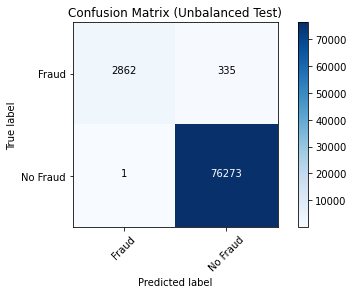

In [0]:
# Plot confusion matrix  
plot_confusion_matrix(cm, "Confusion Matrix (Unbalanced Test)")

In [0]:
# Log MLflow
with mlflow.start_run(experiment_id = experiment_id) as run:
  # Log Parameters and metrics
  mlflow.log_param("balanced", "no")
  mlflow.log_metric("PR train", pr_train)
  mlflow.log_metric("AUC train", auc_train)
  mlflow.log_metric("PR test", pr_test)
  mlflow.log_metric("AUC test", auc_test)
  
  # Log model
  mlflow.spark.log_model(dt_model, "model")
  
  # Log Confusion matrix
  mlflow.log_artifact("confusion-matrix.png")

## Model with Balanced classes

Let's see if we can improve our decision tree model but balancing the Fraud vs. No Fraud cases. We will tune the model using the metrics `areaUnderROC` or (AUC)

In [0]:
# Reset the DataFrames for no fraud (`dfn`) and fraud (`dfy`)
dfn = train.filter(train.label == 0)
dfy = train.filter(train.label == 1)

# Calculate summary metrics
N = train.count()
y = dfy.count()
p = y/N

# Create a more balanced training dataset
train_b = dfn.sample(False, p, seed = 92285).union(dfy)

# Print out metrics
print("Total count: %s, Fraud cases count: %s, Proportion of fraud cases: %s" % (N, y, p))
print("Balanced training dataset count: %s" % train_b.count())

Total count: 318193, Fraud cases count: 12671, Proportion of fraud cases: 0.039821743407303115
Balanced training dataset count: 24788

In [0]:
# Display our more balanced training dataset
display(train_b.groupBy("label").count())

label,count
0,12117
1,12671


### Update ML pipeline
Because we had created the ML pipeline stages in the previous cells, we can re-use them to execute it against our balanced dataset.

Note, we are using `evaluatorAUC` as our `evaluator` as this is often better for a balanced distribution.

In [0]:
# Re-run the same ML pipeline (including parameters grid)
crossval_b = CrossValidator(estimator = dt,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluatorAUC,
                          numFolds = 3)  

pipelineCV_b = Pipeline(stages=[indexer, va, crossval_b])

# Train the model using the pipeline, parameter grid, and BinaryClassificationEvaluator using the `train_b` dataset
cvModel_b = pipelineCV_b.fit(train_b)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
# Build the best model (balanced training and full test datasets)
train_pred_b = cvModel_b.transform(train_b)
test_pred_b = cvModel_b.transform(test)

# Evaluate the model on the balanced training datasets
pr_train_b = evaluatorPR.evaluate(train_pred_b)
auc_train_b = evaluatorAUC.evaluate(train_pred_b)

# Evaluate the model on full test datasets
pr_test_b = evaluatorPR.evaluate(test_pred_b)
auc_test_b = evaluatorAUC.evaluate(test_pred_b)

# Print out the PR and AUC values
print("PR train:", pr_train_b)
print("AUC train:", auc_train_b)
print("PR test:", pr_test_b)
print("AUC test:", auc_test_b)

PR train: 0.9979553517784725
AUC train: 0.9958172204245916
PR test: 0.9924467307973518
AUC test: 0.9975426103389711

In [0]:
# Create temporary view for test predictions
test_pred_b.createOrReplaceTempView("test_pred_b")

# Create test predictions confusion matrix
test_pred_b_cmdf = spark.sql("select a.label, a.prediction, coalesce(b.count, 0) as count from cmt a left outer join (select label, prediction, count(1) as count from test_pred_b group by label, prediction) b on b.label = a.label and b.prediction = a.prediction order by a.label desc, a.prediction desc")

# View confusion matrix
display(test_pred_b_cmdf)

label,prediction,count
1,1,3182
1,0,15
0,1,17
0,0,76257


In [0]:
# Convert to pandas
cm_b_pdf = test_pred_b_cmdf.toPandas()

# Create 1d numpy array of confusion matrix values
cm_b_1d = cm_b_pdf.iloc[:, 2].values

# Create 2d numpy array of confusion matrix vlaues
cm_b = np.reshape(cm_b_1d, (-1, 2))

# Print out the 2d array
print(cm_b)

[[ 3182 15]
 [ 17 76257]]

## View Decision Tree Models
Visually compare the differences between the **unbalanced** and **balanced** decision tree models (basd on the `train` and `train_b` datasets respectively).

In [0]:
# Extract Feature Importance
#  Attribution: Feature Selection Using Feature Importance Score - Creating a PySpark Estimator
#               https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/
import pandas as pd

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [0]:
# View the Unbalanced Decision Tree model (prior to CrossValidator)
dt_model = pipeline.fit(train)
display(dt_model.stages[-1])

treeNode
"{""index"":11,""featureType"":""continuous"",""prediction"":null,""threshold"":-52511.16499999999,""categories"":null,""feature"":6,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":12.375,""categories"":null,""feature"":3,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":56381.0,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":42.09,""categories"":null,""feature"":5,""overflow"":false}"
"{""index"":1,""featureType"":""categorical"",""prediction"":null,""threshold"":null,""categories"":[0.0,1.0],""feature"":0,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":9,""featureType"":""continuous"",""prediction"":null,""threshold"":8059824.115,""categories"":null,""feature"":2,""overflow"":false}"


In [0]:
# Extract Feature Importance for the original unbalanced dt_model
ExtractFeatureImp(dt_model.stages[-1].featureImportances, train_pred, "features").head(10)

Out[31]:

,idx,name,vals,score
5,6,orgDiff,NaN,0.560872
2,3,newbalanceOrig,NaN,0.358220
1,2,oldbalanceOrg,NaN,0.074206
4,5,newbalanceDest,NaN,0.006601
7,0,typeIndexed,"[CASH_OUT, PAYMENT, CASH_IN, TRANSFER, DEBIT]",0.000101
0,1,amount,NaN,0.000000
3,4,oldbalanceDest,NaN,0.000000
6,7,destDiff,NaN,0.000000


In [0]:
# View the Balanced Decision Tree model (prior to CrossValidator)
dt_model_b = pipeline.fit(train_b)
display(dt_model_b.stages[-1])

treeNode
"{""index"":11,""featureType"":""continuous"",""prediction"":null,""threshold"":-39174.43499999998,""categories"":null,""feature"":6,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":12.41,""categories"":null,""feature"":3,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":54763.5,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":42.09,""categories"":null,""feature"":5,""overflow"":false}"
"{""index"":1,""featureType"":""categorical"",""prediction"":null,""threshold"":null,""categories"":[0.0,2.0],""feature"":0,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":9,""featureType"":""continuous"",""prediction"":null,""threshold"":492668.495,""categories"":null,""feature"":1,""overflow"":false}"


In [0]:
# Extract Feature Importance for the nbalanced dt_model
ExtractFeatureImp(dt_model_b.stages[-1].featureImportances, train_pred_b, "features").head(10)

Out[33]:

,idx,name,vals,score
5,6,orgDiff,NaN,0.892727
2,3,newbalanceOrig,NaN,0.058584
1,2,oldbalanceOrg,NaN,0.033847
4,5,newbalanceDest,NaN,0.011532
0,1,amount,NaN,0.001902
7,0,typeIndexed,"[CASH_OUT, TRANSFER, PAYMENT, CASH_IN, DEBIT]",0.001408
3,4,oldbalanceDest,NaN,0.000000
6,7,destDiff,NaN,0.000000


## Comparing Confusion Matrices
Below we will compare the unbalanced and balanced decision tree ML model confusion matrices.

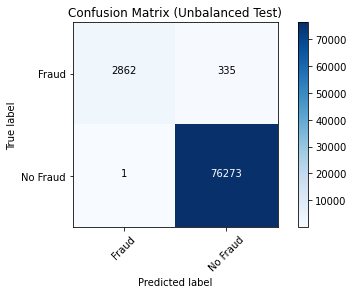

In [0]:
# Plot confusion matrix  
plot_confusion_matrix(cm, "Confusion Matrix (Unbalanced Test)")

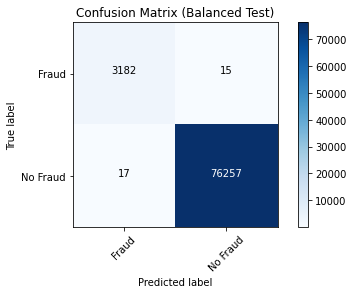

In [0]:
# Plot confusion matrix  
plot_confusion_matrix(cm_b, "Confusion Matrix (Balanced Test)")

In [0]:
# Log MLflow
with mlflow.start_run(experiment_id = experiment_id) as run:
  # Log Parameters and metrics
  mlflow.log_param("balanced", "yes")
  mlflow.log_metric("PR train", pr_train_b)
  mlflow.log_metric("AUC train", auc_train_b)
  mlflow.log_metric("PR test", pr_test_b)
  mlflow.log_metric("AUC test", auc_test_b)
    
  # Log model
  mlflow.spark.log_model(dt_model_b, "model")
  
  # Log Confusion matrix
  mlflow.log_artifact("confusion-matrix.png")

### Observation

There is a significant difference for the `PR` and `AUC` values when comparing the unbalanced vs. balanced decision tree models.

| Metric/dataset | Unbalanced | Balanced |
| -------------- | ---------- | -------- |
| PR train | 0.9537894984523128 | 0.999629161563572 |
| AUC train | 0.998647996459481 | 0.9998071389056655 |
| PR test | 0.9539170535377599 | 0.9904709171789063 |
| AUC test | 0.9984378183482442 | 0.9997903902204509 |

You can also view this data directly within MLflow by comparing the unbalanced vs. balanced decision tree models as noted in the following animated GIF.

![](https://pages.databricks.com/rs/094-YMS-629/images/Fraud Analytics MLflow.gif)